<a href="https://colab.research.google.com/github/MelnikDM/Construction/blob/main/YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загружаем необходимые библиотеки

In [1]:
import os

import random
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm

import matplotlib
import plotly
import PIL
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import yaml
import torch
import json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split

Загрузка YOLO5

In [2]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16088, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 16088 (delta 10), reused 14 (delta 2), pack-reused 16056
Receiving objects: 100% (16088/16088), 14.71 MiB | 23.53 MiB/s, done.
Resolving deltas: 100% (11038/11038), done.
/content/yolov5


In [3]:
%cd /content/yolov5

!pip install -qr requirements.txt
!pip install -q roboflow

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.4/659.4 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.2

## Загрузка датасета




In [4]:
!git clone 'https://github.com/MelnikDM/Construction.git'

Cloning into 'Construction'...
remote: Enumerating objects: 19547, done.
remote: Counting objects: 100% (5987/5987), done.
remote: Compressing objects: 100% (3133/3133), done.
remote: Total 19547 (delta 2855), reused 5982 (delta 2850), pack-reused 13560
Receiving objects: 100% (19547/19547), 1.10 GiB | 30.06 MiB/s, done.
Resolving deltas: 100% (9782/9782), done.
Updating files: 100% (4575/4575), done.


## Обработка аннотаций

И разбиение выборок на обучающую, валидационную и тестовую





In [5]:
classes = {'Helmet':0,'NoHelmet':1, 'NoJacket':2, 'Jacket':3}

In [6]:
!mkdir '/content/yolov5/labels'

In [7]:
for name in os.listdir('/content/yolov5/Construction/HardHat_2/data/Annotations'):
  with open('/content/yolov5/Construction/HardHat_2/data/Annotations/'+name, 'r') as file:
    xml_file = file.read()
    soup = BeautifulSoup(xml_file, 'xml')
    size = soup.find("size")
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    for tag in soup.findAll("object"):
      cls = tag.find("name").text
      xmin = int(tag.find("xmin").text)
      ymin = int(tag.find("ymin").text)
      xmax = int(tag.find("xmax").text)
      ymax = int(tag.find("ymax").text)

      w = xmax - xmin #вычисляем ширину бокса
      h = ymax - ymin #вычисляем высоту бокса
      x = xmin + (w / 2) #находим центр бокса по ширине
      y = ymin + (h / 2) #находим центр бокса по высоте

      #нормируем значения
      x = x / width
      w = w / width
      y = y / height
      h = h / height

      #записываем в файл
      with open('/content/yolov5/labels/'+name[:-3]+'txt', 'a') as f:
        f.write('{} {} {} {} {}\n'.format(classes[cls], x, y, w, h))

In [8]:
image_list = os.listdir('/content/yolov5/Construction/HardHat_2/data/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2)
val_list, test_list = train_test_split(test_list, test_size=0.5)

print('Обучающая выборка: ',len(train_list))
print('Проверочная выборка: ',len(val_list))
print('Тестовая выборка:' ,len(test_list))

Обучающая выборка:  1734
Проверочная выборка:  217
Тестовая выборка: 217


In [9]:
!mkdir '/content/yolov5/images/'
!mkdir '/content/yolov5/images/'
!mkdir '/content/yolov5/images/train/'
!mkdir '/content/yolov5/images/valid/'

mkdir: cannot create directory ‘/content/yolov5/images/’: File exists


In [10]:
# !mkdir '/content/train/'
# !mkdir '/content/valid/'
# !mkdir '/content/train/images/'
# !mkdir '/content/valid/images'
# !mkdir '/content/train/labels'
# !mkdir '/content/valid/labels'

In [10]:
!mkdir '/content/yolov5/labels/train/'
!mkdir '/content/yolov5/labels/valid/'

In [11]:
def move_data(name_list, folder, newfolder, mode, img=True):
  """
  Функция перемещает файлы в указанную папку.
  name_list - список с названиями файлов для перемещения
  folder    - путь к папке откуда берем файл
  mode      - название папки куда перемещаем
  img       - указывает какой тип файла мы перемещаем
  """
  format = 'jpg' if img==True else 'txt'
  for name in name_list:
    name = name[:-3]+format
    # shutil.move(folder + name, folder + '{}/'.format(mode) + name)
    shutil.move(folder + name, newfolder + '{}/'.format(mode) + name)

In [12]:
move_data(train_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'train', img=True)
move_data(val_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'valid', img=True)

In [13]:
move_data(train_list, '/content/yolov5/labels/', '/content/yolov5/labels/', 'train', img=False)
move_data(val_list, '/content/yolov5/labels/', '/content/yolov5/labels/', 'valid', img=False)

## Загрузка и обучение модели Yolo_v5

In [14]:
yaml_file = {'train':'/content/yolov5/images/train',
             'val': '/content/yolov5/images/valid',
             'nc' : '4',
             'names' : ['Helmet', 'NoHelmet', 'NoJacket', 'Jacket']}

with open('helmet.yaml', 'w') as file:
    documents = yaml.dump(yaml_file, file)

Для начала создадим 2 baseline со следующими параметрами: batch 16/32, epochs 5. Веса возьмем по дефолту.

In [15]:
!python train.py --img 640 --batch 16 --epochs 5 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt

2023-12-07 08:49:27.607210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 08:49:27.607278: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 08:49:27.607326: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, 

In [16]:
!python train.py --img 640 --batch 32 --epochs 5 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt

2023-12-07 08:56:59.369545: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 08:56:59.369598: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 08:56:59.369634: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, 

Продолжим наблюдения, увеличив количество эпох до 30

In [17]:
!python train.py --img 640 --batch 16 --epochs 30 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt

2023-12-07 09:04:14.256142: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 09:04:14.256210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 09:04:14.256249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD,

In [18]:
!python train.py --img 640 --batch 32 --epochs 30 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt

2023-12-07 09:44:18.945230: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 09:44:18.945286: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 09:44:18.945329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD,

Теперь попробуем сымитировать Transfer Learning и возьмем лучшие веса, увеличим батч до 64, а количество эпох до 50. Для ускорения заморозим первые 10 слоев модели.

In [19]:
!python train.py --img 640 --batch 64 --epochs 50 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights /content/yolov5/runs/train/exp4/weights/best.pt --freeze 10

2023-12-07 10:24:41.810335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 10:24:41.810384: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 10:24:41.810421: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=/content/yolov5/runs/train/exp4/weights/best.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=Fa

И ради эксперимента возьмем наши лучшие гиперпараметры из прошлой модели и применим их на модели с парамерами batch 32/epochs 30.

In [20]:
!python train.py --img 640 --batch 32 --epochs 30 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights /content/yolov5/runs/train/exp5/weights/best.pt

2023-12-07 11:25:22.614813: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 11:25:22.614872: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 11:25:22.614912: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=/content/yolov5/runs/train/exp5/weights/best.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=Fa

А теперь посмотрим, что будет если мы попробуем решить проблему "в лоб". Берем batch 32, а epochs 50. Модель учим "с нуля" и без "заморозки" первых слоев.

In [29]:
!python train.py --img 640 --batch 32 --epochs 50 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt

2023-12-07 12:14:14.575106: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 12:14:14.575180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 12:14:14.575231: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD,

Отобразим график результатов модели batch 32/epochs 30 с гиперпараметрами от модели 64/50.

In [21]:
from PIL import Image
from matplotlib import pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

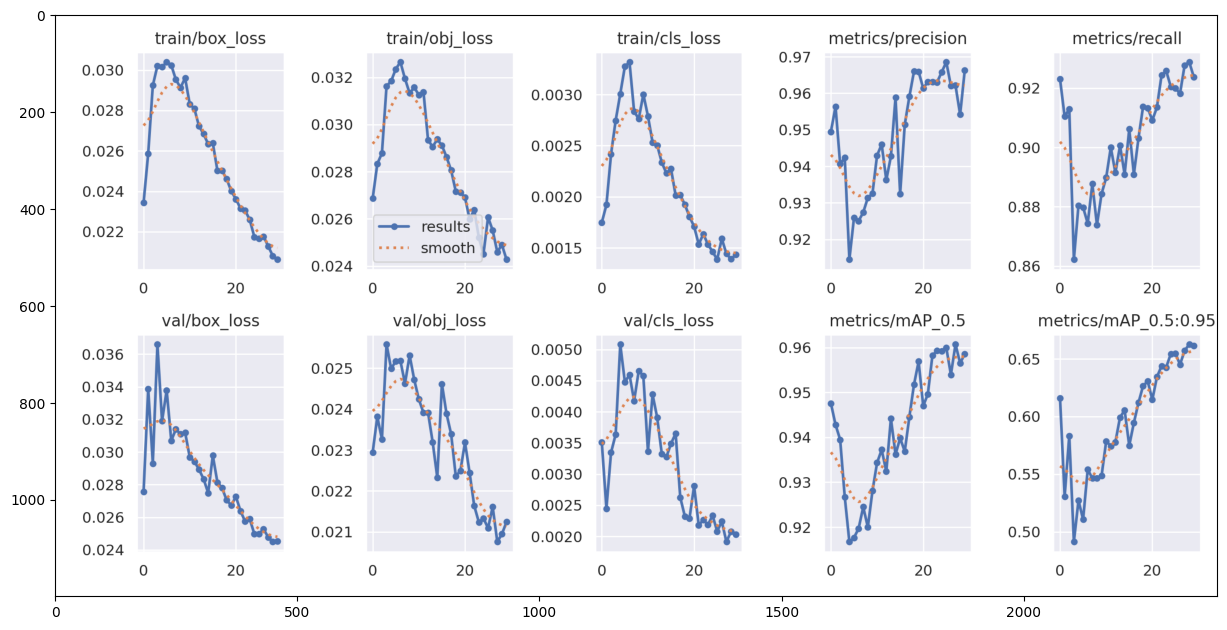

In [22]:
img = Image.open('/content/yolov5/runs/train/exp6/results.png')
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show

## Проверка на тестовой выборке

In [23]:
!mkdir '/content/yolov5/images/test/'
move_data(test_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'test', img=True)

In [24]:
!python detect.py --img 640 --source /content/yolov5/images/test/  --weights /content/yolov5/runs/train/exp6/weights/best.pt --conf 0.25

detect: weights=['/content/yolov5/runs/train/exp6/weights/best.pt'], source=/content/yolov5/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20865057 parameters, 0 gradients, 47.9 GFLOPs
image 1/217 /content/yolov5/images/test/HardHat0336_jpg.rf.e5d18c6f3b6119db7e650ee06d1c2317.jpg: 640x640 5 NoHelmets, 5 Jackets, 27.0ms
image 2/217 /content/yolov5/images/test/HardHat0342_jpg.rf.2d49d418c46964aa1d4e87edc684dd8a.jpg: 640x640 10 Helmets, 4 NoJackets, 27.1ms
image 3/217 /content/yolov5/

## Выгрузка результатов

In [25]:
!zip -r /content/file_train.zip /content/yolov5/runs/train/exp6/

  adding: content/yolov5/runs/train/exp6/ (stored 0%)
  adding: content/yolov5/runs/train/exp6/val_batch1_labels.jpg (deflated 6%)
  adding: content/yolov5/runs/train/exp6/val_batch2_pred.jpg (deflated 4%)
  adding: content/yolov5/runs/train/exp6/opt.yaml (deflated 50%)
  adding: content/yolov5/runs/train/exp6/results.png (deflated 6%)
  adding: content/yolov5/runs/train/exp6/train_batch0.jpg (deflated 1%)
  adding: content/yolov5/runs/train/exp6/P_curve.png (deflated 12%)
  adding: content/yolov5/runs/train/exp6/val_batch2_labels.jpg (deflated 4%)
  adding: content/yolov5/runs/train/exp6/val_batch0_pred.jpg (deflated 6%)
  adding: content/yolov5/runs/train/exp6/weights/ (stored 0%)
  adding: content/yolov5/runs/train/exp6/weights/best.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp6/weights/last.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp6/confusion_matrix.png (deflated 27%)
  adding: content/yolov5/runs/train/exp6/events.out.tfevents.1701948324.a81fe2595a73.4098

In [26]:
from google.colab import files
files.download("/content/file_train.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
!zip -r /content/file_detect.zip /content/yolov5/runs/detect/exp/

  adding: content/yolov5/runs/detect/exp/ (stored 0%)
  adding: content/yolov5/runs/detect/exp/Hardhat0209_jpg.rf.85face086454b4c10a4a704e0c782be7.jpg (deflated 3%)
  adding: content/yolov5/runs/detect/exp/HardHat0803_jpg.rf.5f742530f71b9271229595f64fa7cde3.jpg (deflated 6%)
  adding: content/yolov5/runs/detect/exp/Hardhat0272_jpg.rf.101967f16ede6e871b5df2ff8535be20.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp/HardHat0773_jpg.rf.81ab02184aea40178a3b44fbdccb7f66.jpg (deflated 6%)
  adding: content/yolov5/runs/detect/exp/Hardhat0077_jpg.rf.7481de2ffc98bbd04e9b0ce7e556d9b6.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp/HardHat0696_jpg.rf.7ec3d99bb1eecbafc642f8dee648e55a.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp/HardHat0342_jpg.rf.2d49d418c46964aa1d4e87edc684dd8a.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp/HardHat0506_jpg.rf.debf5045884b493eee2a84d242f8cadf.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp/Hardhat0127_jpg.r

In [28]:
from google.colab import files
files.download("/content/file_detect.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>